## 3. Tailored pipeline 
This pipeline designed to test different docking tools in parellel, it consists of 4 main steps:

#### 1. Data prepartion :

- In this step, two different steps are implemented:
1. Protein is prepared with protoss on ProteinPlus server (Done).
2. Ligand will be prepared using Gypsum-DL.

#### 2. Docking :
- Four docking tools are implemented using score data:
    1. SMINA
    2. GNINA
    3. PLANTS
    4. SeeSAR


#### 3. Rescoring :
- Six scoring functions are tested and compared between each others 
    1. RFscoreVS
    2. VINARDO
    3. AD4
    4. oddt (RFscoreVS_v1, RFscoreVS_v2, RFscoreVS_v3) All were trained on PDBbind 2016
            


#### 4. Clustering (Later):
- In order to decrease dimensionality of the data, Butina clustering is implemented using tanimoto similarity metric on the fingerprints.
- It will be implemented on larger data.

## Results 


### Tailored pipeline 

#### Best rank correlation is :

1. Pipeline 1 has Spearman correlation equals $0.5612$
    - No Filtering
    - Smina
    - oddt : RF_Score_V3




2. Pipeline 2 has Pearson correlation equals $0.5567$
    - Filtering using MCS (20 micromolar, IC50, 120 molecules out of 212) 
    - GNINA
    - None


3. Pipeline 3 has Pearson correlation equals $0.5329$
    - Filtering using MCS (20 micromolar, IC50, 120 molecules out of 212) 
    - SMINA or GNINA (GNINA better with) $0.0009$
    - AD4



4. Pipeline 4 has spearman correlation equals $0.5311$
    - No filtering
    - GNINA 
    - No scoring fucntion


#### - Best scoring functions yet are AD4 and RFScoreVS_V3.
#### - Least correlated scoring fucntions are NNscore, PLEClinear, PLECnn and PLECrf, Excluded!

## Import important dependencies and paths

In [51]:
import os 
import numpy as np
import pandas as pd
from clustering import *
from data_preparation import *
from docking import *
from filtering import *
from rdkit.ML.Cluster import Butina
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, SDMolSupplier, AllChem, rdFingerprintGenerator
from scipy.stats import spearmanr
from rescoring import rescoring_functions
from pathlib import Path
from matplotlib import pyplot as plt
from utility import *

In [52]:
HERE = Path(_dh[-1])
DATA = HERE / "data"
software = HERE / "software"

#### If there is more than one snapshot of a trajectory.
- make a directory for all snapshots inside **data** directory
- For now , we work with snapshot A

In [53]:
snapshot_ID = 'A'

In [54]:
protein_file = DATA / snapshot_ID / "protein_protoss_noligand.pdb"
ref_file =  DATA / snapshot_ID / "ref_ligand.pdb"
data_suffix = 'new_ecf_score_final'

### Load IC50 data

In [55]:
df_IC50 = PandasTools.LoadSDF('data/ligands/IC50_mol_only.sdf')
df_IC50.head()

,Activity,smiles,ID,ROMol
0,3.1,O=C(O)c1cc(OCc2cccc(-c3cccc(Oc4ccc(C(F)(F)F)cc...,HIPS6989,<rdkit.Chem.rdchem.Mol object at 0x7f7c3c0bc510>
1,3.2,O=C(O)c1cc(OCc2cccc(-c3cccc(OCc4ccc(OC(F)(F)F)...,HIPS7002,<rdkit.Chem.rdchem.Mol object at 0x7f7c3c0bdfc0>
2,3.5,O=C(O)c1cc(OCc2cccc(-c3cccc(OCc4ccc(C(F)(F)F)c...,HIPS7000,<rdkit.Chem.rdchem.Mol object at 0x7f7c3c0bd2a0>
3,4.7,Cc1ccc(Oc2cccc(-c3cccc(COc4ccc(O)c(C(=O)O)c4)c...,HIPS6994,<rdkit.Chem.rdchem.Mol object at 0x7f7c3c0bc350>
4,5.0,O=C(O)c1cc(OCc2cccc(-c3cccc(Oc4ccc(Cl)cc4)c3)c...,HIPS6991,<rdkit.Chem.rdchem.Mol object at 0x7f7c3c0bd4d0>


### Load larger dataset with negative samples with pre-calculated scores

In [56]:
df_scores = PandasTools.LoadSDF('data/ligands/ecft_scores_new_cleaned.sdf')
df_scores.head()

,score,Lab code,MW,logS,logS @ pH7.4,logD,logP,HBD,HBA,TPSA,Flexibility,Rotatable Bonds,ID,ROMol
0,-0.734039,AK333,486.6,-1.568,1.984,2.67,6.395,2,6,78.87,0.2895,11,HIPS6128,<rdkit.Chem.rdchem.Mol object at 0x7f7c3c293f40>
1,-0.708889,JHS130,497.4,-1.731,1.797,3.322,6.614,2,5,69.64,0.2222,8,HIPS449,<rdkit.Chem.rdchem.Mol object at 0x7f7c3c293df0>
2,-0.680817,FLPR43-001P-1,480.4,-1.063,1.929,2.877,6.753,2,5,75.99,0.2105,8,HIPS6989,<rdkit.Chem.rdchem.Mol object at 0x7f7c3c0bd230>
3,-0.677414,FLPR43-001S-1,510.5,-1.123,2.03,3.06,6.451,2,6,85.22,0.25,10,HIPS7002,<rdkit.Chem.rdchem.Mol object at 0x7f7c3c293a00>
4,-0.669659,FLPR43-001H-1,494.5,-1.099,1.616,3.061,6.755,2,5,75.99,0.2308,9,HIPS7000,<rdkit.Chem.rdchem.Mol object at 0x7f7c3c2934c0>


#### Map correlation between IC50 data and score data

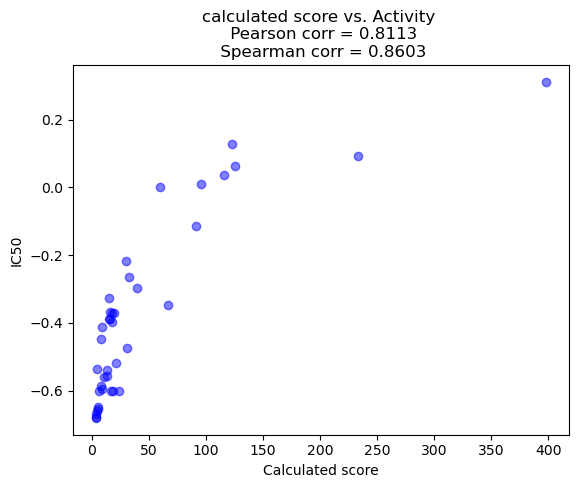

In [57]:
merged_df_data = pd.merge(df_IC50, df_scores, on="ID", how="left")
merged_df_data[['score', 'Activity']] = merged_df_data[['score', 'Activity']].apply(pd.to_numeric)

pearson_corr = merged_df_data['Activity'].corr(merged_df_data['score'])
spearman_corr = merged_df_data[['Activity', 'score']].corr(method='spearman').iloc[0,1]

plt.scatter(merged_df_data['Activity'], merged_df_data['score'], c='blue', alpha=0.5)
plt.xlabel('Calculated score')
plt.ylabel('IC50')
plt.title(f'calculated score vs. Activity \n Pearson corr = {pearson_corr:.4f}\n Spearman corr = {spearman_corr:.4f}')
plt.show()

### Extract common IDs from score data and IC50 data

In [58]:
common_ID = df_scores[df_scores['ID'].isin(df_IC50['ID'])]['ID']
print(f"There are {len(common_ID)} structures that found to be common in both data sets.")

There are 39 structures that found to be common in both data sets.


### Data preparation
####  1. Protein is prepared with protoss on ProteinPlus server (Done).
####  2. Ligand will be prepared using Gypsum-DL.

In [59]:
# Determine path of data set and run Gypsum-dl
#prepared_molecules_path = run_gypsumdl(f"data/ligands/ecft_scores_new_cleaned.sdf", f"gypsum_dl_success_cleaned_{data_size}")

## Docking

## 1. GNINA docking 

#### Run GNINA docking

In [60]:
sdf_name = f'docked_gnina_poses_{snapshot_ID}_new_ecf_score_final.sdf'

In [61]:
#gnina_docking(snapshot_ID, sdf_name, prepared_molecules_path, ref_file, "32", 10)

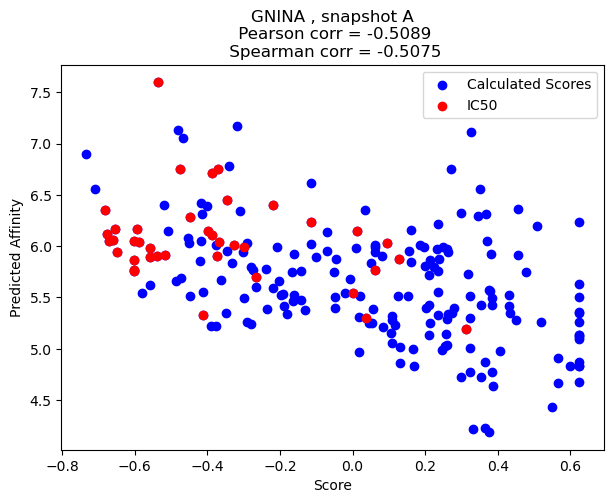

In [62]:
gnina_results_path = DATA / snapshot_ID / sdf_name
rank_correlation(str(gnina_results_path), common_ID)

### 2. SMINA docking

#### Run SMINA docking --cnn_scoring=none

In [63]:
sdf_name = f'docked_smina_poses_{snapshot_ID}_new_ecf_score_final.sdf'

In [64]:
#smina_docking(snapshot_ID, sdf_name, prepared_molecules_path, ref_file)

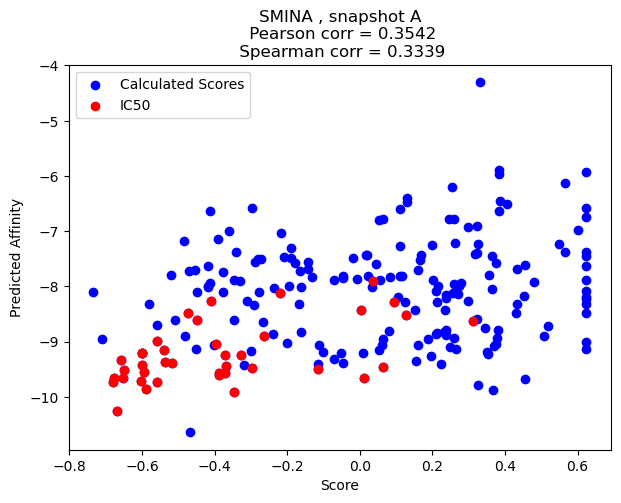

In [65]:
smina_results_path = f'data/{snapshot_ID}/{sdf_name}'
rank_correlation(smina_results_path, common_ID)

### 3. PLANTS docking

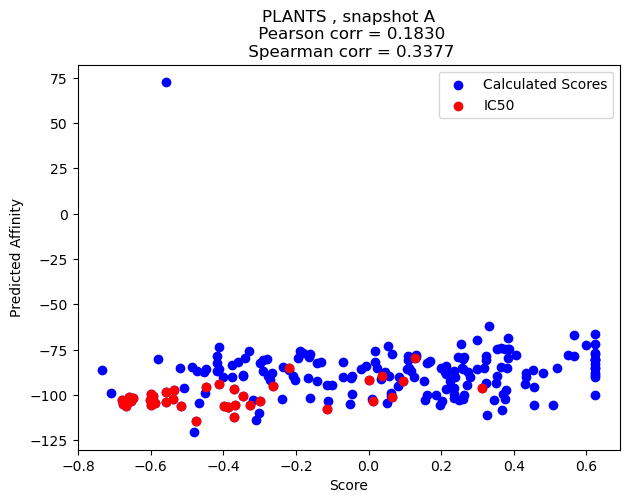

In [66]:
sdf_name = f'docked_plants_poses_{snapshot_ID}_new_ecf_score_final.sdf'
plants_results_path = f'data/{snapshot_ID}/{sdf_name}'
rank_correlation(plants_results_path, common_ID)

### 4. SeeSAR docking

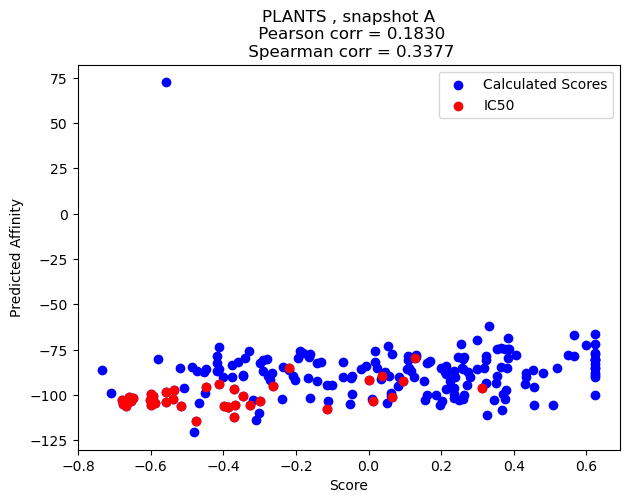

In [67]:
sdf_name = f'docked_seesar_poses_{snapshot_ID}_new_ecf_score_final.sdf'
seesar_results_path = f'data/{snapshot_ID}/{sdf_name}'
rank_correlation(plants_results_path, common_ID)

### Try rescoring functions with every possbile combination of two docking tools and three rescoring functions.

rescoring directory is already created.
SMINA is now rescored ... 



RF-SCORE-VS Running ... 





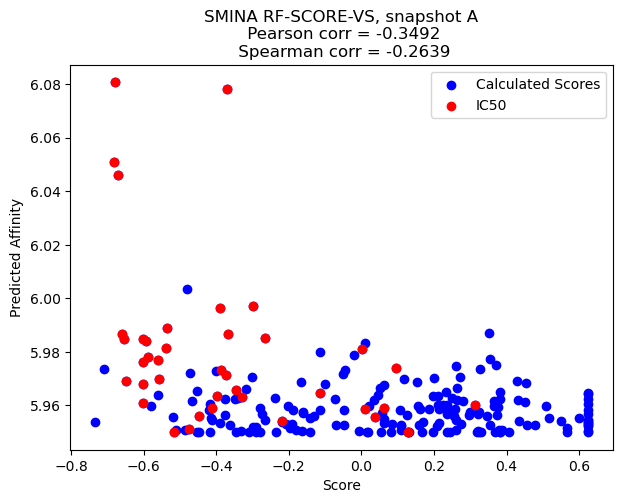

VINARDO Running ... 





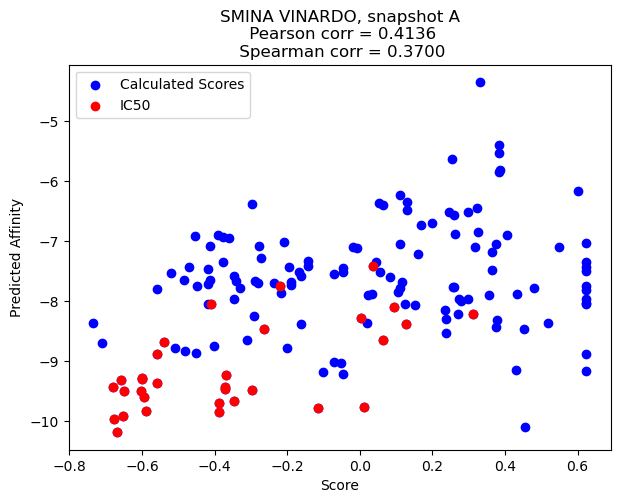

AD4 Running ... 





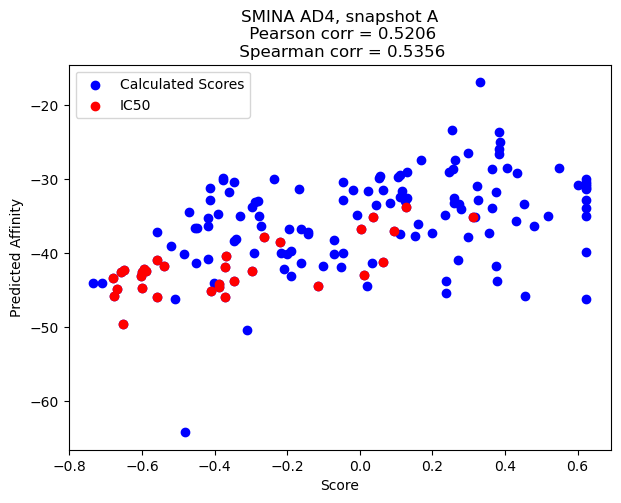

ODDT Running ... 





KeyboardInterrupt: 

In [68]:
rescoring_functions(['smina', 'plants', 'gnina', 'seesar'], [ 'rf-score-vs','vinardo', 'ad4', 'oddt'], snapshot_ID, data_size, common_ID)

_"The number of features to consider when looking for the best split in each RF tree (“mtry”) was optimized using out-of-bag predictions (OOB). The optimized values are: 15 for v1 and v3 and 100 for v2 used in this study"_